### Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The drug to study
agent = "Trastuzumab"
# Include anything with the agent name
combination_therapy = True
# The gene to examine
gene = "ERBB2"
# cancerTypeDetailed or cancerType
analysis_type = 'cancerType'
# The cancer type
ctype = "Breast Cancer"
# Modifier to the date (how many days earlier the sequencing can be from start of treatment)
modifier = 20
# Modifier to the date (how many days after still counts for death)
modifier_after = 50

In [3]:
config = "../global_config_bash.rc"

Automatically generated

In [4]:
with open(config, 'r') as f :
    bash_script_content = f.read()
    lines = bash_script_content.splitlines()
paths = {}
for line in lines:
    line = line.strip()
    if line and '=' in line:
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        # Handle variable references
        while '${' in value:
            start_index = value.find('${')
            end_index = value.find('}', start_index)
            if start_index != -1 and end_index != -1:
                variable_name = value[start_index + 2:end_index]
                if variable_name in paths:
                    value = value[:start_index] + paths[variable_name] + value[end_index + 1:]
                else:
                    break  # Stop if variable reference not found
        paths[key] = value.strip('"\'')  # Remove surrounding quotes if any

In [5]:
# Merged ECHO results
# echo = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.ECHO_results.csv')
# FileA in the manifest directory
# manifest = pd.read_csv(paths['manifestDirectory'] + '/FileA.tsv', sep = '\t')

echo = pd.read_csv("../data/output/output_BB_EchoCaller_Breast_ERBB2/merged/merged.ECHO_results.csv")
manifest = pd.read_csv("../data/input/manifest/BB_EchoCaller_Breast_ERBB2/FileA.tsv", sep = '\t')

In [6]:
progression = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_progression.txt', sep = '\t')
sequencing = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_specimen.txt', sep = '\t')
timeline_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_timeline_follow_up.txt', sep = '\t')
treatment_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_treatment.txt', sep = '\t')

### Setup

ECHO dataframe

In [7]:
echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'oncotreeCode', 'msiScore', 'msiType', 'mutationCount', 'fractionAltered','osStatus', 'osMonths', 'deIDAge', 'stageHighest']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')


per sample

In [8]:
echo = echo[echo[analysis_type] == ctype]

per_sample = pd.DataFrame(echo['tumorSampleId'].unique(), columns = ['sampleId'])
per_sample['amp'] = False
per_sample['ecDNA'] = False
per_sample['patientId'] = ""
per_sample['cn'] = 2

# Dict for indexes in dataframe
per_sample_idx = {}
for i, row in per_sample.iterrows() :
    per_sample_idx[row['sampleId']] = i
    per_sample.loc[i, 'patientId'] = row['sampleId'].split('-')[0] + '-' + row['sampleId'].split('-')[1]

for i, row in echo.iterrows() :
    if row['gene'] == gene :
        per_sample.loc[per_sample_idx[row['tumorSampleId']], 'amp'] = True
        if row['ecDNA_status'] == 'ecDNA' :
            per_sample.loc[per_sample_idx[row['tumorSampleId']], 'ecDNA'] = True
        per_sample.loc[per_sample_idx[row['tumorSampleId']], 'cn'] = row['cn']

# Combined status
per_sample['combined'] = "No ecDNA & No Amp"
for i, row in per_sample.iterrows() :
    if row['ecDNA'] :
        per_sample.loc[i, 'combined'] =  "ecDNA & Amp"       
    elif row['amp'] :
        per_sample.loc[i, 'combined'] =  "No ecDNA & Amp"       

get timeline data

In [9]:
death_dict = {}

for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Patient Deceased" :
        death_dict[row['PATIENT_ID']] = row['START_DATE']

In [10]:
last_contact_dict = {}

for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Last Contact" :
        last_contact_dict[row['PATIENT_ID']] = row['START_DATE']

In [11]:
progression_positive = progression[progression['PROGRESSION'] == 'Yes']

sequencing_dict = {}
for i, row in sequencing.iterrows() :
    sequencing_dict[row['SAMPLE_ID']] = row['START_DATE']

progression_by_patient = {}
for i, row in progression_positive.iterrows() :
    if row['PATIENT_ID'] in progression_by_patient :
        progression_by_patient[row['PATIENT_ID']].append(row['START_DATE'])
    else :
        progression_by_patient[row['PATIENT_ID']] = [row['START_DATE']]

In [12]:
treatment_dict = {}
for i, row in treatment_data.iterrows() :
    if combination_therapy :
        if agent in row['AGENT'] :
            if row['PATIENT_ID'] in treatment_dict :
                treatment_dict[row['PATIENT_ID']].append((row['START_DATE'], row['STOP_DATE']))
            else :
                treatment_dict[row['PATIENT_ID']] = [(row['START_DATE'], row['STOP_DATE'])]
    else :
        if row['AGENT'] == agent :
            if row['PATIENT_ID'] in treatment_dict :
                treatment_dict[row['PATIENT_ID']].append((row['START_DATE'], row['STOP_DATE']))
            else :
                treatment_dict[row['PATIENT_ID']] = [(row['START_DATE'], row['STOP_DATE'])]


In [13]:
per_sample['progressedOrDeceased'] = False
per_sample['deceased'] = False
per_sample['pfs'] = np.nan
per_sample['os'] = np.nan

# Iterate all samples
for i, row in per_sample.iterrows() :
    if row['sampleId'] in sequencing_dict :
        seq_time = sequencing_dict[row['sampleId']]
    
        # Iterate all treatment dates for that sample
        if row['patientId'] in treatment_dict :
            for date_pair in treatment_dict[row['patientId']] :
    
                # If we find a date pair that covers the sequence time
                if date_pair[0] - modifier < seq_time and (date_pair[1] == np.nan or date_pair[1] > seq_time) :
                    if date_pair[1] == np.nan :
                        end_date = 1000000
                        os_date = 1000000
                    else :
                        end_date = date_pair[1]
                        os_date = date_pair[1]
    
                    # Go through progression dates
                    if row['patientId'] in progression_by_patient :
                        for prog_date in progression_by_patient[row['patientId']] :
                            if prog_date > date_pair[0] and prog_date < date_pair[1] :
                                per_sample.loc[i, 'progressedOrDeceased'] = True
                                end_date = min(end_date, prog_date)
    
                    # Check if patient has died
                    if row['patientId'] in death_dict :
                        if death_dict[row['patientId']] <= end_date + modifier_after :
                            end_date = min(end_date, death_dict[row['patientId']])
                            per_sample.loc[i, 'progressedOrDeceased'] = True
                            per_sample.loc[i, "deceased"] = True
                            os_date = death_dict[row['patientId']]
    
                    # Add last contact possibility
                    if row['patientId'] in last_contact_dict :
                        end_date = min(end_date, last_contact_dict[row['patientId']])
                        os_date = min(os_date, last_contact_dict[row['patientId']])

                    if end_date != 1000000 :
                        per_sample.loc[i, 'pfs'] = end_date - date_pair[0] 
                    
                    if os_date != 1000000 :
                        per_sample.loc[i, 'os'] = os_date - date_pair[0] 
    else :
        print(f"{row['sampleId']} Sequencing Date Not Found")

P-0000358-T01-IM3 Sequencing Date Not Found
P-0033620-T01-IM6 Sequencing Date Not Found


In [14]:
per_sample_for_km = per_sample.dropna(subset = ["pfs"])
per_sample_for_os_km = per_sample.dropna(subset = ['os'])

### Results

Progression Free

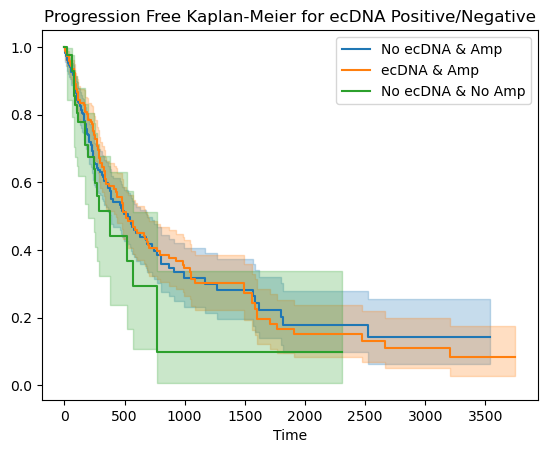

In [15]:
import warnings
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Ignore all warnings
warnings.filterwarnings('ignore')

kmf = KaplanMeierFitter()
for status in per_sample_for_km['combined'].unique():
    subset = per_sample_for_km[per_sample_for_km['combined'] == status]
    kmf.fit(subset['pfs'], event_observed=(subset['progressedOrDeceased'] == True))
    # labels
    kmf.plot(show_censors=False, ci_show=True, label=f'{status}')

# # Add labels and legend
plt.title('Progression Free Kaplan-Meier for ecDNA Positive/Negative')
plt.xlabel("Time")
plt.legend()

In [16]:
from itertools import combinations
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

statuses = per_sample_for_km['combined'].unique()
pairwise_tests = {}

for group1, group2 in combinations(statuses, 2) :
    group1_data = per_sample_for_km[per_sample_for_km['combined'] == group1]
    group2_data = per_sample_for_km[per_sample_for_km['combined'] == group2]

    # Fit KM curves
    kmf.fit(group1_data['pfs'], event_observed=(group1_data['combined'] == 1))
    kmf2.fit(group2_data['pfs'], event_observed=(group2_data['combined'] == 1))
    
    # Perform log-rank test
    result = logrank_test(group1_data['pfs'], group2_data['pfs'], event_observed_A=(group1_data['progressedOrDeceased'] == True), event_observed_B=(group2_data['progressedOrDeceased'] == True))
    
    # Store p-value in dictionary
    pairwise_tests[(group1, group2)] = result.p_value

p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
for (group1, group2), p_value in pairwise_tests.items():
    if group1 != group2:
        p_values_matrix.loc[group1, group2] = p_value
p_values_matrix = p_values_matrix.fillna("")

print("P-values for KM Curves")

styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}, {
    'selector': 'td',
    'props': [('border', '1px solid black')]
}])
styled_matrix

P-values for KM Curves


,ecDNA & Amp,No ecDNA & No Amp
No ecDNA & Amp,0.748383,0.209304
ecDNA & Amp,,0.103428


Overall Survival

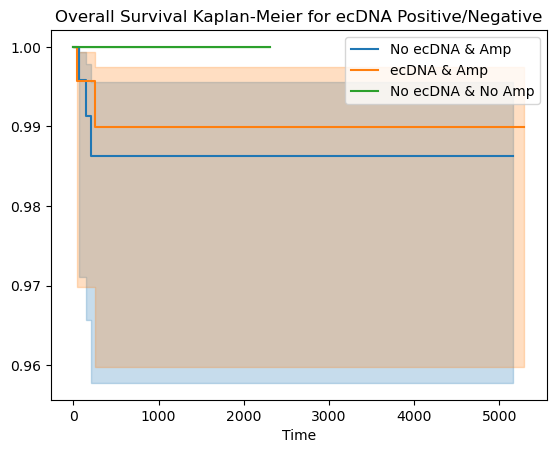

In [17]:
import warnings
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Ignore all warnings
warnings.filterwarnings('ignore')

kmf = KaplanMeierFitter()
for status in per_sample_for_os_km['combined'].unique():
    subset = per_sample_for_os_km[per_sample_for_os_km['combined'] == status]
    kmf.fit(subset['os'], event_observed=(subset['deceased'] == True))
    # labels
    kmf.plot(show_censors=False, ci_show=True, label=f'{status}')

# # Add labels and legend
plt.title('Overall Survival Kaplan-Meier for ecDNA Positive/Negative')
plt.xlabel("Time")
plt.legend()

In [18]:
from itertools import combinations
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

statuses = per_sample_for_os_km['combined'].unique()
pairwise_tests = {}

for group1, group2 in combinations(statuses, 2) :
    group1_data = per_sample_for_os_km[per_sample_for_os_km['combined'] == group1]
    group2_data = per_sample_for_os_km[per_sample_for_os_km['combined'] == group2]

    # Fit KM curves
    kmf.fit(group1_data['os'], event_observed=(group1_data['combined'] == 1))
    kmf2.fit(group2_data['os'], event_observed=(group2_data['combined'] == 1))
    
    # Perform log-rank test
    result = logrank_test(group1_data['os'], group2_data['os'], event_observed_A=(group1_data['deceased'] == True), event_observed_B=(group2_data['deceased'] == True))
    
    # Store p-value in dictionary
    pairwise_tests[(group1, group2)] = result.p_value

p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
for (group1, group2), p_value in pairwise_tests.items():
    if group1 != group2:
        p_values_matrix.loc[group1, group2] = p_value
p_values_matrix = p_values_matrix.fillna("")

print("P-values for KM Curves")

styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}, {
    'selector': 'td',
    'props': [('border', '1px solid black')]
}])
styled_matrix

P-values for KM Curves


,ecDNA & Amp,No ecDNA & No Amp
No ecDNA & Amp,0.722085,0.493806
ecDNA & Amp,,0.564914


### Other Statistics

Progression Free

In [19]:
specific_cox_df = pd.DataFrame(columns = ['atype', 'p_value', 'hazardRatio', 'upper', 'lower'])

gene_cox = per_sample_for_km.dropna(subset = ['pfs', 'progressedOrDeceased', 'ecDNA', 'amp'])
gene_cox['progressedOrDeceased'] = gene_cox['progressedOrDeceased'].astype(int)
from lifelines import CoxPHFitter

# Just ecDNA +/-
cox = CoxPHFitter()
covariates = ['pfs', 'progressedOrDeceased', 'ecDNA']
cox.fit(gene_cox[covariates], duration_col = 'pfs', event_col = 'progressedOrDeceased')
new_row = {
    'atype' : "ecDNA Status",
    'p_value' : cox.summary['p'][0],
    'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
    'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
    'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
}
new_df = pd.DataFrame([new_row])
specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)

# ecDNA plus echo amplification status
cox = CoxPHFitter()
covariates = ['pfs', 'progressedOrDeceased', 'amp', 'ecDNA']
cox.fit(gene_cox[covariates], duration_col = 'pfs', event_col = 'progressedOrDeceased')
new_row = {
    'atype' : "ecDNA Status + ECHO Amp",
    'p_value' : cox.summary['p'][0],
    'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
    'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
    'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
}

new_df = pd.DataFrame([new_row])
specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)

# ecDNA plus copy number
cox = CoxPHFitter()
covariates = ['pfs', 'progressedOrDeceased', 'cn', 'ecDNA']
cox.fit(gene_cox[covariates], duration_col = 'pfs', event_col = 'progressedOrDeceased')
new_row = {
    'atype' : "ecDNA Status + Copy Number",
    'p_value' : cox.summary['p'][0],
    'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
    'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
    'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
}

new_df = pd.DataFrame([new_row])
specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)

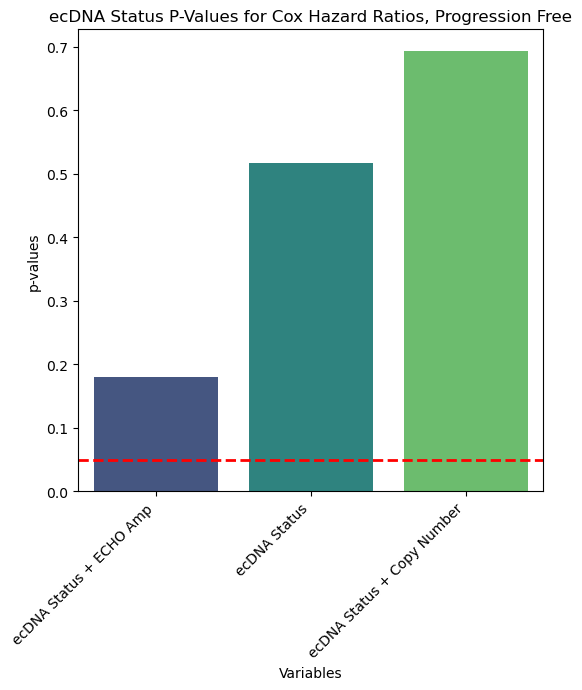

In [20]:
import seaborn as sns

specific_cox_df = specific_cox_df.sort_values(by='p_value')
plt.figure(figsize=(6, 6))
bars = sns.barplot(x='atype', y='p_value', data=specific_cox_df, palette='viridis')
plt.xlabel('Variables')
plt.ylabel('p-values')
plt.title('Sorted DataFrame Bar Plot')
bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2)
plt.title("ecDNA Status P-Values for Cox Hazard Ratios, Progression Free")
plt.show()

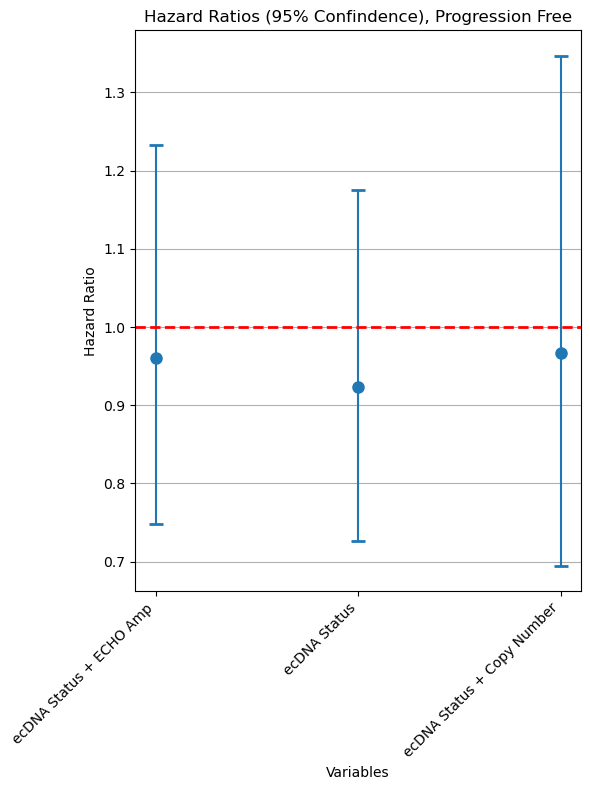

In [21]:
non_zero = specific_cox_df[specific_cox_df['lower'] != 0]

# Number of rows in the DataFrame
num_rows = non_zero.shape[0]

# Plotting points with error bars for each row
plt.figure(figsize=(6, 8))

# Plot points
positions = np.arange(num_rows)
plt.errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
             fmt='o', markersize=8, capsize=5, capthick=2)

# Set x-axis ticks and labels
plt.xlabel('Variables')
plt.xticks(positions, non_zero['atype'],rotation=45, ha='right')


# Add labels and title
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratios (95% Confindence), Progression Free')
plt.axhline(y=1, color='r', linestyle='--', linewidth=2)

plt.grid(True, axis='y')  # Add grid lines for better visualization
plt.tight_layout()
plt.show()

Overall Survival

In [25]:
specific_cox_df = pd.DataFrame(columns = ['atype', 'p_value', 'hazardRatio', 'upper', 'lower'])

gene_cox = per_sample_for_km.dropna(subset = ['os', 'deceased', 'ecDNA', 'amp'])
gene_cox['deceased'] = gene_cox['deceased'].astype(int)
from lifelines import CoxPHFitter

# Just ecDNA +/-
cox = CoxPHFitter()
covariates = ['os', 'deceased', 'ecDNA']
cox.fit(gene_cox[covariates], duration_col = 'os', event_col = 'deceased')
new_row = {
    'atype' : "ecDNA Status",
    'p_value' : cox.summary['p'][0],
    'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
    'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
    'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
}
new_df = pd.DataFrame([new_row])
specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)

# ecDNA plus echo amplification status
cox = CoxPHFitter()
covariates = ['os', 'deceased', 'amp', 'ecDNA']
cox.fit(gene_cox[covariates], duration_col = 'os', event_col = 'deceased')
new_row = {
    'atype' : "ecDNA Status + ECHO Amp",
    'p_value' : cox.summary['p'][0],
    'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
    'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
    'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
}

new_df = pd.DataFrame([new_row])
specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)

# ecDNA plus copy number
cox = CoxPHFitter()
covariates = ['os', 'deceased', 'cn', 'ecDNA']
cox.fit(gene_cox[covariates], duration_col = 'os', event_col = 'deceased')
new_row = {
    'atype' : "ecDNA Status + Copy Number",
    'p_value' : cox.summary['p'][0],
    'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
    'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
    'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
}

new_df = pd.DataFrame([new_row])
specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)

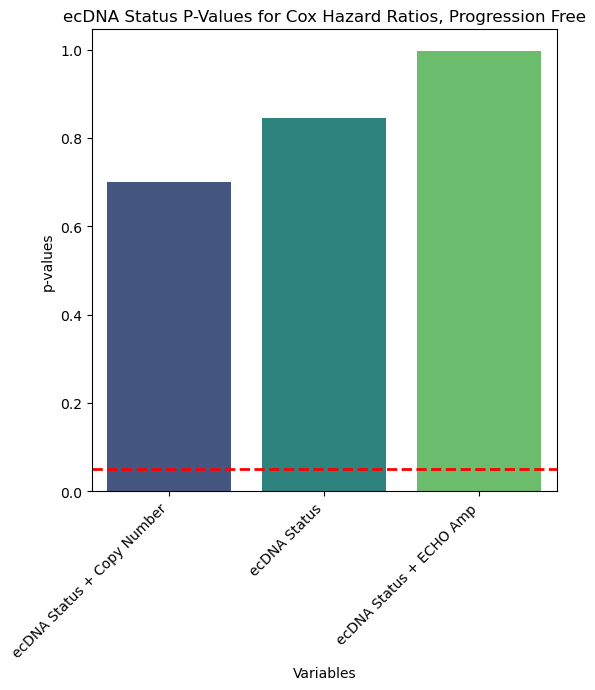

In [26]:
import seaborn as sns

specific_cox_df = specific_cox_df.sort_values(by='p_value')
plt.figure(figsize=(6, 6))
bars = sns.barplot(x='atype', y='p_value', data=specific_cox_df, palette='viridis')
plt.xlabel('Variables')
plt.ylabel('p-values')
plt.title('Sorted DataFrame Bar Plot')
bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2)
plt.title("ecDNA Status P-Values for Cox Hazard Ratios, Progression Free")
plt.show()

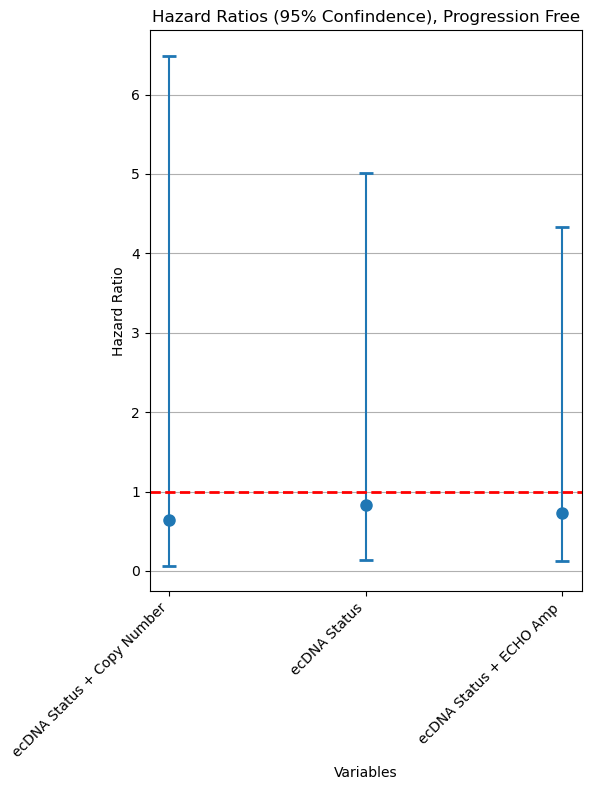

In [27]:
non_zero = specific_cox_df[specific_cox_df['lower'] != 0]

# Number of rows in the DataFrame
num_rows = non_zero.shape[0]

# Plotting points with error bars for each row
plt.figure(figsize=(6, 8))

# Plot points
positions = np.arange(num_rows)
plt.errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
             fmt='o', markersize=8, capsize=5, capthick=2)

# Set x-axis ticks and labels
plt.xlabel('Variables')
plt.xticks(positions, non_zero['atype'],rotation=45, ha='right')


# Add labels and title
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratios (95% Confindence), Progression Free')
plt.axhline(y=1, color='r', linestyle='--', linewidth=2)

plt.grid(True, axis='y')  # Add grid lines for better visualization
plt.tight_layout()
plt.show()